<a href="https://colab.research.google.com/github/WesleyKhoiVo/ViViT-action/blob/main/src/data-preprocessing/UBI_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting packets and labels fron UBI Fights dataset

Packet size = 28 frames * 28 W * 28 H

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mohanad's UCF extraction

```python
def extract_frames(root,
                   label,
                   out,
                   packet_shape=INPUT_SHAPE,
                   overlap=0):
  '''
  summary:
  transform videos located at root into 2 numpy arrays [X, y] loacated at out
  '''
  # initiate packets counter
  n_class_packets = 0

  # initiate packet
  packet = np.empty(packet_shape,
                    dtype=np.uint8)
  
  # unique packet frames count
  n_unique_frames = packet_shape[0] - overlap

  # intiate extracted frames X ndarray
  with NpyAppendArray(out + 'X.npy') as npaa:

    # loop on videos locations
    for subdir, _, videos_paths in [*os.walk(root)]:
      for video_path in videos_paths:

        # initate capture
        cap = cv2.VideoCapture(subdir + os.sep + video_path)
        
        # print('full_path', subdir + os.sep +  video_path)

        # TODO: Reformulate considering overlaps
        # Calculate packets per video
        n_video_packets = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // n_unique_frames
        # print(n_video_packets)

        # accumulate class whole packets count
        n_class_packets += n_video_packets
        

        # initiate video packets array
        video_packets = np.empty((n_video_packets,) + packet_shape,
                                dtype=np.uint8)
        
        # loop on video frames
        for i in range(n_video_packets):
          # loop on packet size
          for j in range(packet_shape[0]):
            
              # read the frame
              _, frame = cap.read()

              # NOTE: is it the best interpolation?
              # resize frame shape
              frame = cv2.resize(frame, packet_shape[1:], interpolation=cv2.INTER_AREA)

              # assure grayscale
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

              # assign to packet
              packet[j] = frame

          # assign to video packets
          video_packets[i] = packet
       
        cv2.destroyAllWindows()
        
        # print(video_packets.shape)
        # save video packets
        npaa.append(video_packets)

  print('for', label, n_class_packets)
  # save labels array
  # NOTE: EXPERIMENTAL
  y = np.full((n_class_packets, 1), label, dtype=np.uint8)
  with NpyAppendArray(out + 'y.npy') as npaa:
    npaa.append(y)
```

In [3]:
! pip install npy_append_array scikit-video opencv-python scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.1 MB/s eta 0:00:00


In [4]:
from npy_append_array import NpyAppendArray as npaa
import matplotlib.pyplot as plt
import skvideo.io
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import gc
from typing import Tuple
import cv2
from time import perf_counter
from skimage.transform import resize

In [11]:
!wget "http://socia-lab.di.ubi.pt/EventDetection/UBI_FIGHTS.zip" -P "/content/drive/My Drive/Datasets/"

--2023-07-02 06:45:29--  http://socia-lab.di.ubi.pt/EventDetection/UBI_FIGHTS.zip
Resolving socia-lab.di.ubi.pt (socia-lab.di.ubi.pt)... 193.136.67.244
Connecting to socia-lab.di.ubi.pt (socia-lab.di.ubi.pt)|193.136.67.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8117112419 (7.6G) [application/zip]
Saving to: ‘/content/drive/My Drive/Datasets/UBI_FIGHTS.zip’

UBI_FIGHTS.zip      100%[===================>]   7.56G  1.53MB/s    in 1h 48m  

2023-07-02 08:34:27 (1.18 MB/s) - ‘/content/drive/My Drive/Datasets/UBI_FIGHTS.zip’ saved [8117112419/8117112419]



In [12]:
!unzip "/content/drive/My Drive/Datasets/UBI_FIGHTS.zip"

Archive:  /content/drive/My Drive/Datasets/UBI_FIGHTS.zip
   creating: UBI_FIGHTS/
   creating: UBI_FIGHTS/annotation/
  inflating: UBI_FIGHTS/annotation/N_0_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_1_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_2_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_3_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_4_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_5_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_6_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_7_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_8_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_9_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_10_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_11_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_12_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_13_0_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_14_1_0_1_0.csv  
  inflating: UBI_FIGHTS/annotation/N_15_0_0_1_0.csv  
  inflating: UBI_FIGHTS/ann

In [5]:
#ROOT = '/gdrive/MyDrive/Datasets/UBI_FIGHTS/UBI_FIGHTS_v2/UBI_FIGHTS'
ROOT = '/content/drive/My Drive/Datasets/UBI_FIGHTS'
VIDEOS = ROOT + '/videos'
ANNOTATIONS = ROOT + '/annotation'
OUT = ROOT + '/extracted'
#OUT = '/gdrive/MyDrive/Datasets/UBI_FIGHTS/extracted'

In [6]:
PACKET_SHAPE = (28, 28, 28)
VIOLENT = 1
NON_VIOLENT = 0

In [7]:
video_paths = sorted(glob(VIDEOS + '/**/*.mp4'))
annot_paths = sorted(glob(ANNOTATIONS + '/*.csv'))

In [8]:
class Extractor():
    def __init__(self,
                 packet_shape = PACKET_SHAPE,
                 overlap = 0,
                 backend_read='opencv'
                ) -> None:
        assert len(packet_shape) == 3 , f'Packet shape { packet_shape } should be in the format: (number of frames, width, height)'
        assert backend_read == 'opencv' or backend_read == 'scikit'
        assert overlap == 0, 'This feature is not yet implemented'
        self.packet_shape = packet_shape
        self.overlap = overlap
        self.backend_read = backend_read

    # Read the data
    def video_to_np(self, path, verbose=False):
        shape = self.packet_shape[1:]
        if self.backend_read == 'opencv':
            cap = cv2.VideoCapture(path)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            video = np.zeros((n_frames,) + shape)
            loop = range(n_frames)
            if verbose:
                loop = tqdm(loop)
            for i in loop:
                _, frame = cap.read()
                frame = cv2.resize(frame, shape, interpolation=cv2.INTER_AREA)
                video[i] = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

            cv2.destroyAllWindows()

        else: # 'scikit'
            temp = skvideo.io.vread(path)
            video = np.zeros((temp.shape[0],) + shape)

            if verbose:
                print('Resizing...')

            resized = np.zeros((temp.shape[0],) + shape + (3,))

            for i in range(temp.shape[0]):
                resized[i] = cv2.resize(temp[i], shape, interpolation=cv2.INTER_AREA)

            if verbose:
                print('Converting to grayscale...')

            video = np.dot(resized, [0.299, 0.587, 0.114])

        return video / 255.

    def extract_packets_ubi(self,
        video_path: str,
        annotation_path: str,
        verbose = False
    ) -> Tuple[np.ndarray, np.ndarray]:
        ''' This function always outputs grayscale packets '''

        tick = None
        if verbose:
            print(f'Reading video ...')
            tick = perf_counter()
        video = self.video_to_np(video_path, verbose)
        if verbose:
            tock = perf_counter() - tick if tick is not None else 0
            print(f'Video reading took {tock} sec.')

        lbl = np.genfromtxt(
            annotation_path,
            delimiter=",", dtype=int
        )
        anchor = np.where(np.diff(lbl) != 0)[0]

        # initialize placeholders for output
        shape_x = (1 + len(video) // self.packet_shape[0],) + self.packet_shape
        shape_y = (shape_x[0],1)
        count = 0
        y = np.zeros(shape_y)
        x = np.zeros(shape_x)

        # fill in output
        current = lbl[0]
        nxt_anchor = anchor[0] if anchor.shape[0] != 0 else np.inf
        idx = 0
        for i in range(0, len(video), self.packet_shape[0] - self.overlap):
            packet = np.zeros(self.packet_shape)
            temp = video[i: i + self.packet_shape[0]]
            packet[:len(temp)] = temp
            del temp
            x[count] = packet
            y[count] = current
            if i >= nxt_anchor:
                current = lbl[i + 1]
                idx = idx + 1
                nxt_anchor = anchor[idx] if idx < anchor.shape[0] else np.inf
            count = count + 1

        return (x, y)

    def get_shapes(self,paths):
        final = 0
        for path in tqdm(paths):
            cap = cv2.VideoCapture(path)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cv2.destroyAllWindows()
            final = final + 1 + n_frames // self.packet_shape[0]
        shape_x = (final,) + self.packet_shape
        shape_y = (final, 1)
        return shape_x, shape_y

    def __map_vid_to_lbl_paths(self,
                               video_paths: list[str],
                               annot_paths: list[str],
                               ext = 'csv'
                            ) -> dict[str,str]:
        '''
        Warning: This function assumes all video paths are from the same directory and the same for annotations
        '''
        map = {}
        root = '/'.join(annot_paths[0].split('/')[:-1])
        for p in video_paths:
            token = p.split('/')[-1].split('.')[0]
            map[p] = f'{root}/{token}.{ext}'
        return map



    def packets_from_paths(self, video_paths, annot_paths, out_path):
        skipped = []
        print('Calculating shapes ...')
        _ , shape_y = self.get_shapes(video_paths)
        map = self.__map_vid_to_lbl_paths(video_paths,annot_paths)
        y = np.zeros(shape_y)
        start = 0
        print('Processing files ...')
        with npaa(out_path+'/x.npy') as x:
            for video_path in tqdm(video_paths):
                annot_path = map[video_path]
                if not os.path.exists(annot_path):
                    skipped.append(video_path)
                    continue
                x_sub, y_sub = (self.extract_packets_ubi(video_path, annot_path))
                x.append(x_sub)
                end = y_sub.shape[0] + start
                y[start:end] = y_sub
                start = end
                for _ in range(10):
                    gc.collect()
        np.save(out_path+'/y.npy',y)
        print('The following files were skipped because no annotation file was found')
        print(skipped)



(155, 28, 28, 28) (155, 1)


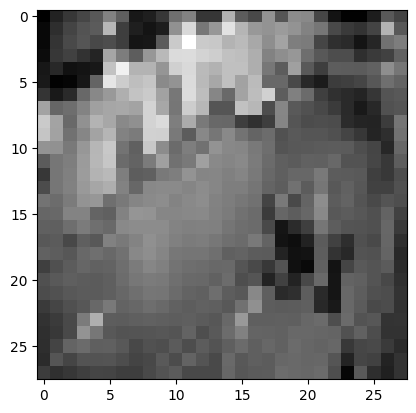

In [9]:
ext = Extractor()
x, y = ext.extract_packets_ubi(video_paths[0], annot_paths[0])
print(x.shape, y.shape)
plt.imshow(x[8,8],cmap='gray')
plt.show()

Reading video ...


100%|██████████| 4320/4320 [00:12<00:00, 355.39it/s]


Video reading took 12.230326921000028 sec.


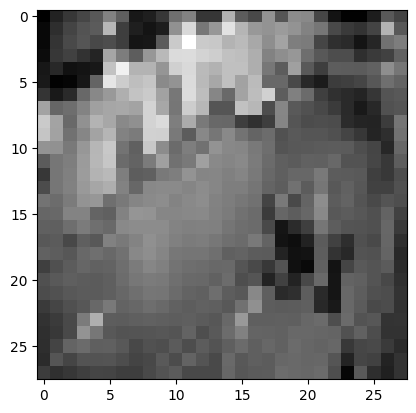

In [12]:
x, y = ext.extract_packets_ubi(video_paths[0], annot_paths[0],verbose=True)
plt.imshow(x[8,8],cmap='gray')
plt.show()

In [14]:
ext = Extractor()
ext.get_shapes(video_paths)

100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


((305272, 28, 28, 28), (305272, 1))

In [15]:
for _ in tqdm(range(100)):
    gc.collect()

100%|██████████| 100/100 [00:07<00:00, 12.55it/s]
